In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ir_metrics import precision_at_k, recall_at_k, f1_score_at_k

# CLIP's input limit: 77 Tokens

In [ ]:
import json
import tiktoken
import numpy as np
import os

def count_tokens(text):
    encoding = tiktoken.get_encoding("cl100k_base")
    return len(encoding.encode(text))

# Directory containing JSON files
directory_path = "/vast/marco/Data/json/2020/"

# List all JSON files in the directory
json_files = [f for f in os.listdir(directory_path) if f.endswith(".json")]

token_counts = []

# Read each JSON file and process it
for json_file in json_files:
    file_path = os.path.join(directory_path, json_file)
    
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)
    
    # Extract "first claim" field and count tokens
    for key, value in data.items():
        if "first_claim" in value:
            token_count = count_tokens(value["first_claim"])
            token_counts.append(token_count)

# Compute the mean of token counts
mean_tokens = np.mean(token_counts) if token_counts else 0
std_dev_tokens = np.std(token_counts) if token_counts else 0

# Print results
#print("Processed files:", json_files)
#print("Token counts:", token_counts)
print("Mean token count:", mean_tokens)
print("Standard deviation of token count:", std_dev_tokens)

Processed files: ['I20200107.json', 'I20200114.json', 'I20200121.json', 'I20200128.json', 'I20200204.json', 'I20200211.json', 'I20200218.json', 'I20200225.json', 'I20200303.json', 'I20200310.json', 'I20200317.json', 'I20200324.json', 'I20200331.json', 'I20200407.json', 'I20200414.json', 'I20200421.json', 'I20200428.json', 'I20200505.json', 'I20200512.json', 'I20200519.json', 'I20200526.json', 'I20200602.json', 'I20200609.json', 'I20200616.json', 'I20200623.json', 'I20200630.json', 'I20200707.json', 'I20200714.json', 'I20200721.json', 'I20200728.json', 'I20200804.json', 'I20200811.json', 'I20200818.json', 'I20200825.json', 'I20200901.json', 'I20200908.json', 'I20200915.json', 'I20200922.json', 'I20200929.json', 'I20201006.json', 'I20201013.json', 'I20201020.json', 'I20201027.json', 'I20201103.json', 'I20201110.json', 'I20201117.json', 'I20201124.json', 'I20201201.json', 'I20201208.json', 'I20201215.json', 'I20201222.json', 'I20201229.json']
Token counts: [198, 118, 125, 125, 607, 306, 2

#  Performance Plot

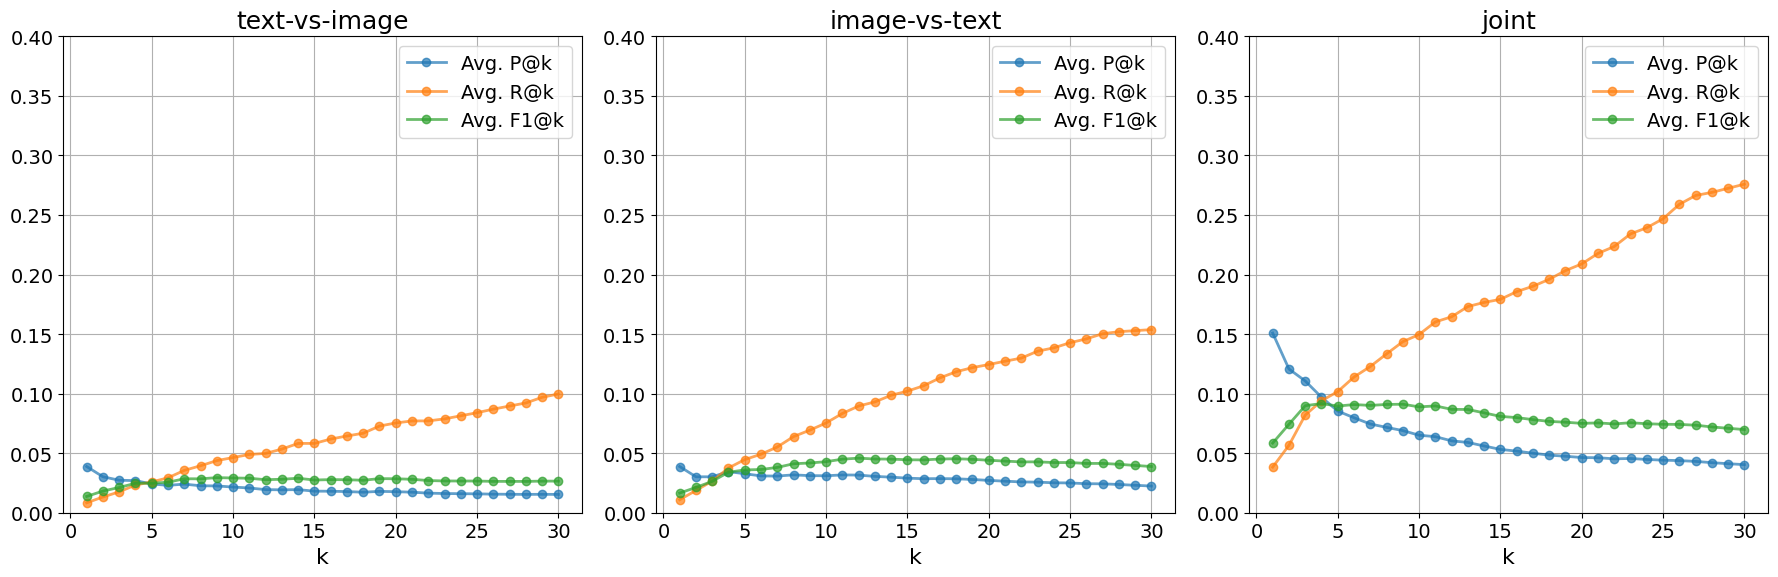

In [3]:
results_file = '/home/fantoni/marco/patent-clip/docker/results_for_evaluation/A42B3-A62B18-H02K19-custom.json'

# Open file which contain search results
with open(results_file, 'r') as f:
    results = json.load(f)

# Create ground truth
truth_1 = '/vast/marco/Data_Google_Patent/ground_truth/A42B3.json'
truth_2 = '/vast/marco/Data_Google_Patent/ground_truth/A62B18.json'
truth_3 = '/vast/marco/Data_Google_Patent/ground_truth/H02K19.json'
truths = [truth_1, truth_2, truth_3]
all_truths = {}

for truth in truths:
    if os.path.exists(truth):  # Check if the file exists
        with open(truth, 'r') as f:
            data = json.load(f)
            if isinstance(data, dict):
                all_truths.update(data)  # Merge dictionaries
            else:
                print(f"File {truth} does not contain a dictionary. Skipping.")
    else:
        print(f"File not found: {truth}")

json.dumps(all_truths, indent=4) # dump all the truth files in the dictionary

# Get the list of patent ID of the queries from truth file
Q = list(all_truths.keys()) 
model = os.path.basename(results_file).split('.')[0] # get the name of the model from the json filename 

# Initialize metric storage
metrics = {'text': ([], [], []), 'image': ([], [], []), 'joint': ([], [], [])}
k_values = range(1, 31)

for k in k_values:
    for mode in metrics.keys():
        precisions = [precision_at_k(results[q][mode], all_truths[q], k) for q in Q]
        recalls = [recall_at_k(results[q][mode], all_truths[q], k) for q in Q]
        f1_scores = [f1_score_at_k(results[q][mode], all_truths[q], k) for q in Q]
        
        metrics[mode][0].append(np.mean(precisions))
        metrics[mode][1].append(np.mean(recalls))
        metrics[mode][2].append(np.mean(f1_scores))

# Increase global font size
plt.rcParams.update({'font.size': 14})  # Adjust the number for desired readability

# Plotting
plt.figure(figsize=(18, 6))
titles = ['text-vs-image', 'image-vs-text', 'joint']
colors = ['#1F77B4', '#FF7F0E', '#2CA02C']
labels = ['Avg. P@k', 'Avg. R@k', 'Avg. F1@k']

for i, mode in enumerate(metrics.keys()):
    plt.subplot(1, 3, i + 1)
    for j, metric in enumerate(metrics[mode]):
        plt.plot(k_values, metric, label=labels[j], marker='o', color=colors[j], alpha=0.7, markersize=6, linewidth=2)
    
    plt.ylim(0, 0.4)
    plt.xlabel("k", fontsize=16)
    plt.ylabel("", fontsize=16)
    plt.title(titles[i], fontsize=18)
    plt.legend(loc='upper right', fontsize=14)  
    plt.grid(True)

plt.tight_layout()
plt.show()

# Performance Table

In [5]:
# Initialize an empty list to store rows for the DataFrame
rows = []

# Construct rows for the DataFrame from the metrics dictionary
for k in k_values:
    for mode in metrics.keys():
        precision = round(metrics[mode][0][k-1], 3)
        recall = round(metrics[mode][1][k-1], 3)
        f1_score = round(metrics[mode][2][k-1], 3)
        # Append row as a tuple (k, mode, precision, recall, f1)
        rows.append((k, mode, precision, recall, f1_score))     

df = pd.DataFrame(rows, columns=['k', 'modality', 'Avg. Precision@k', 'Avg. Recall@k', 'Avg. F1-score@k'])
df = df[df['k'].isin([1, 3, 5, 10, 15, 20, 25, 30])]

from IPython.display import display, HTML
display(HTML(df.to_html(index=False)))

k,modality,Avg. Precision@k,Avg. Recall@k,Avg. F1-score@k
1,text,0.039,0.008,0.014
1,image,0.039,0.011,0.017
1,joint,0.151,0.038,0.058
3,text,0.027,0.018,0.021
3,image,0.030,0.027,0.026
3,joint,0.111,0.082,0.090
5,text,0.024,0.026,0.025
5,image,0.033,0.045,0.036
5,joint,0.085,0.102,0.090
10,text,0.022,0.046,0.029


# Visualize Distribution of IPC classes
within retrieved document patents

    Class  A42B3  A62B18  H02K19
0   A42B3    713      56       6
1  A62B18     73     289      18
2  H02K19      3      16     141
            A42B3     A62B18     H02K19
Class                                  
A42B3   92.000000   7.225806   0.774194
A62B18  19.210526  76.052632   4.736842
H02K19   1.875000  10.000000  88.125000


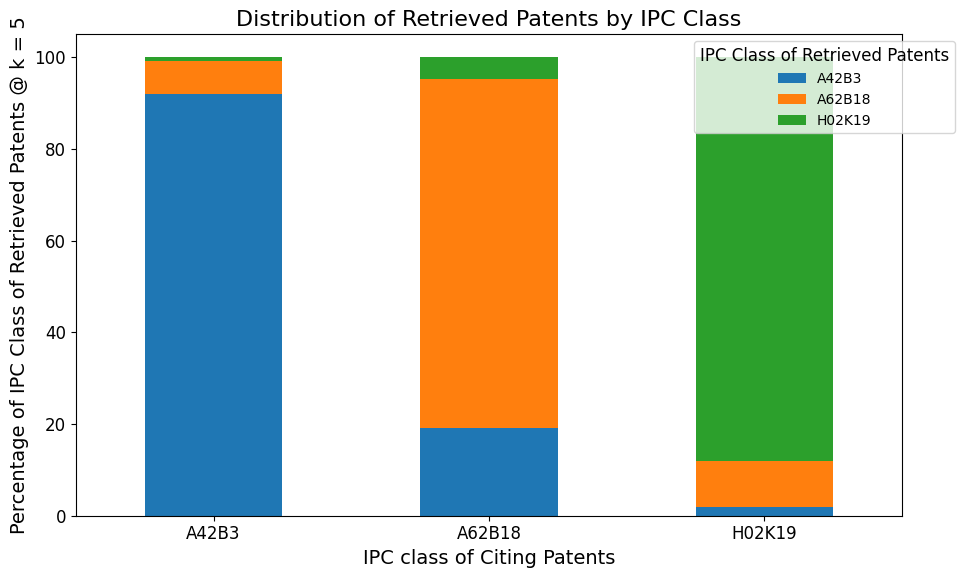

In [4]:
import pandas as pd
from collections import Counter

results_file = '/home/fantoni/marco/patent-clip/docker/results_for_evaluation/A42B3-A62B18-H02K19-custom.json'

with open(results_file, 'r') as f:
    results = json.load(f)

k = 5
mode = 'joint'
data = {}
for query, result in results.items():
    query_cls = query.split('_')[0] # get the class of the query
    doc_cls_list = [doc.split('_')[0] for doc in result[mode][:k]] # get the class of the documents retrieved by 'joint'
    if query_cls not in data:
        data[query_cls] = []
    data[query_cls].extend(doc_cls_list) 

df = pd.DataFrame([{"Class": cls, **Counter(doc_cls)} for cls, doc_cls in data.items()])
print(df)

# Normalize counts to percentages
df_percentage = df.set_index('Class').apply(lambda x: x / x.sum() * 100, axis=1)
print(df_percentage)

# Plot
df_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))

# Increase font sizes for readability
plt.ylabel(f'Percentage of IPC Class of Retrieved Patents @ k = {k}', fontsize=14)
plt.xlabel('IPC class of Citing Patents', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Distribution of Retrieved Patents by IPC Class", fontsize=16)

# Adjust legend font size
plt.legend(title='IPC Class of Retrieved Patents', loc='upper left', bbox_to_anchor=(0.74, 1), fontsize=10, title_fontsize=12)

# Ensure layout does not overlap
plt.tight_layout()

plt.show()
